# Masked Auto-Encoder

We will explore the popular self-supervised masked auto-encoder approach [MAE](https://arxiv.org/pdf/2111.06377v2).

The work is divided in the following parts:

* **Part A**: Create a dataset and a data module to handle the PneumoniaMNIST dataset.
* **Part B**: Implement MAE utility functions.
* **Part C**: Implement and train a full MAE model.
* **Part D**: Inspect the trained model.

## Setup

In [24]:
# On Google Colab uncomment the following line to install PyTorch Lightning and the MedMNIST dataset
#! pip install lightning medmnist timm

In [25]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms
from pytorch_lightning import LightningModule, LightningDataModule, Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from torchmetrics.functional import auroc
from PIL import Image
from medmnist.info import INFO
from medmnist.dataset import MedMNIST

## **Part A**: Create a dataset and a data module to handle the PneumoniaMNIST dataset.

We will be using the [MedMNIST Pneumonia](https://medmnist.com/) dataset, which is a medical imaging inspired dataset but with the characteristics of MNIST. This allows efficient experimentation due to the small image size. The dataset contains real chest X-ray images but here downsampled to **28 x 28 pixels**, with binary labels indicating the presence of [Pneumonia](https://www.nhs.uk/conditions/pneumonia/) (which is an inflammation of the lungs).

### A-1. Complete the dataset implementation.

We implement a dataset class `PneumoniaMNISTDataset` suitable for training a classification model. For each sample, your dataset class should return one image and the corresponding label. We won't use the labels during training but for simplicity we will return them for model inspection purposes (part D).

In terms of augmentation, we want to follow what has been done in the original MAE paper, that is **use random cropping (70%-100%) and horizontal flipping only** (see paragraph Data augmentation, page 6 of the [paper](https://arxiv.org/pdf/2111.06377v2) for further details).

In [26]:
class PneumoniaMNISTDataset(MedMNIST):
    def __init__(self, split = 'train', augmentation: bool = False):
        ''' Dataset class for Pneumonia MNST.
        The provided init function will automatically download the necessary
        files at the first class initialistion.

        :param split: 'train', 'val' or 'test', select subset

        '''
        self.flag = "pneumoniamnist"
        self.size = 28
        self.size_flag = ""
        self.root = './data/coursework/'
        self.info = INFO[self.flag]
        self.download()

        npz_file = np.load(os.path.join(self.root, "pneumoniamnist.npz"))

        self.split = split

        # Load all the images
        assert self.split in ['train','val','test']

        self.imgs = npz_file[f'{self.split}_images']
        self.labels = npz_file[f'{self.split}_labels']

        self.do_augment = augmentation


        # Transformations
        self.transform = transforms.Compose([
            transforms.ToPILImage(),  # Convert from numpy to PIL
            transforms.RandomResizedCrop(size=self.size, scale=(0.7, 1.0)), # Randomly crop the image (70-100% of the original size)
            transforms.RandomHorizontalFlip(p=0.5), # Randomly flip the image horizontally
            transforms.ToTensor()  # Convert from PIL to tensor
        ]) if self.do_augment else transforms.ToTensor()  # If there is no augmentation, just convert to a tensor

    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, index):
        img = self.imgs[index] # Get the image from index
        label = self.labels[index] # Get the label from index
        img = self.transform(img) # Apply the transformation to the image
        return img, label

We use a [LightningDataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) for handling your PneumoniaMNIST dataset. No changes needed for this part.

In [27]:
class PneumoniaMNISTDataModule(LightningDataModule):
    def __init__(self, batch_size: int = 32):
        super().__init__()
        self.batch_size = batch_size
        self.train_set = PneumoniaMNISTDataset(split='train', augmentation=True)
        self.val_set = PneumoniaMNISTDataset(split='val', augmentation=False)
        self.test_set = PneumoniaMNISTDataset(split='test', augmentation=False)

    def train_dataloader(self):
        return DataLoader(dataset=self.train_set, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_set, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_set, batch_size=self.batch_size, shuffle=False)

#### **Check** dataset implementation.

Run the below cell to visualise a batch of your training dataloader.

Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz


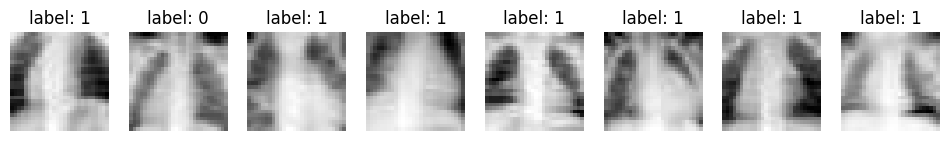

In [28]:
# DO NOT MODIFY THIS CELL! IT IS FOR CHECKING THE IMPLEMENTATION ONLY.

# Initialise data module
datamodule = PneumoniaMNISTDataModule()
# Get train dataloader
train_dataloader = datamodule.train_dataloader()
# Get first batch
batch = next(iter(train_dataloader))
# Visualise the images
images, labels = batch
f, ax = plt.subplots(1, 8, figsize=(12,4))
for i in range(8):
  ax[i].imshow(images[i, 0], cmap='gray')
  ax[i].set_title('label: ' + str(labels[i].item()))
  ax[i].axis("off")

## **Part B**: Implement MAE utility functions.

Masked Auto-Encoders are based on a [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929) architecture. Importantly, the ViT architecture operates on a patch-level, not on the image-level. Hence, to feed the image into the ViT based encoder first we need to divide the images in small patches (typically 16x16 pixels).

In this part, we ask you to write three utility functions:

* `patchify`: takes in a batch of images (N, C, H, W) where N is the batch size, and returns a batch of patches of size (N, L, D) where L is the number of patches fitting in one image and D = patch_size\** 2*C.
* `unpatchify`: inverts the above operation, takes in a batch of patches of size (N, L, D) and returns the corresponding a batch of images (N, C, H, W).
* `random_masking`: Randomly masks out patches during training to create a self-supervised training task of patch prediction.

### **Task B-1:** Implement `patchify`

In [29]:
def patchify(imgs, patch_size):
        """
        patch_size: (patch_h, patch_w)
        """
        ### ADD YOUR CODE HERE

        N, C, H, W = imgs.shape
        patch_h, patch_w = patch_size

        # Check if H and W are divisible by patch size
        assert H % patch_h == 0, "H is not divisible by patch_h"
        assert W % patch_w == 0, "W is not divisible by patch_w"

        # Calculate number of patches
        L = (H // patch_h) * (W // patch_w)

        # Extract patches
        patches = imgs.unfold(2, patch_h, patch_h).unfold(3, patch_w, patch_w)

        # Calculate D
        D = patch_h * patch_w * C
        
        # Reshape patches to (N, L, D)
        patches = patches.reshape(N, L, D)
        return patches

Let's test our implementation on the first batch of the validation set.

In [30]:
# Load a batch of validation images
datamodule = PneumoniaMNISTDataModule()
dataloader = datamodule.val_dataloader()
batch = next(iter(dataloader))
images, labels = batch

Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz


In [31]:
images.shape

torch.Size([32, 1, 28, 28])

In [32]:
# Assuming a patch size of (4,4) test your patchify function
# and test that the shape of the outputs corresponds at what is expected
patch_size = (4,4)
patches = patchify(images, (4, 4))

In [33]:
patches.shape

torch.Size([32, 49, 16])

#### Visualisation of patchify output
Next, we want to check our output visually. In the next cell, plot all the patches of the first image in the batch as a grid of subplots where subplot(i,j) shows patch(i,j) at the right position in the original image. You should be able to recognise the original image.

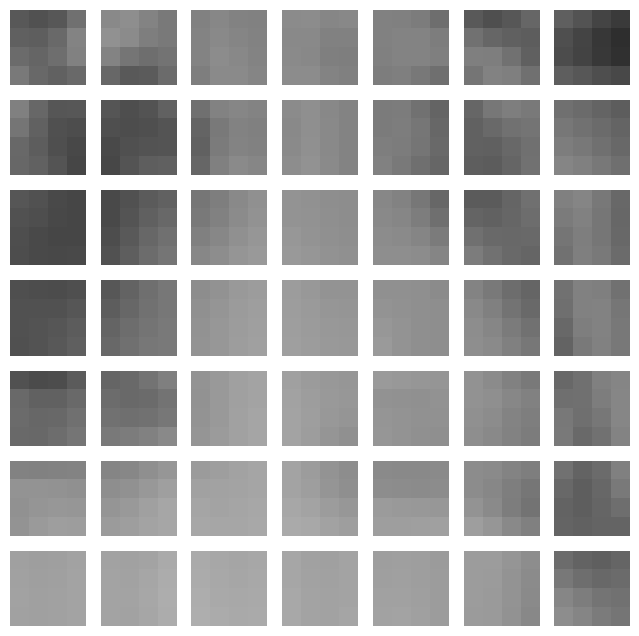

In [34]:
# Plot the patches of the first image

patches1 = patches[0]
plot_dim = int(np.sqrt(patches1.shape[0]))

_, ax = plt.subplots(plot_dim, plot_dim, figsize=(8,8))

for i in range(plot_dim):
    for j in range(plot_dim):
        # Fix the color range to [0, 1]
        ax[i, j].imshow(patches1[i*plot_dim+j].reshape(patch_size[0], patch_size[1]), cmap='gray', vmin=0, vmax=1)
        #ax[i, j].imshow(patches1[i*plot_dim+j].reshape(patch_size[0], patch_size[1]), cmap='gray')
        ax[i, j].axis('off')

Compare the ouput with the original image

(-0.5, 27.5, 27.5, -0.5)

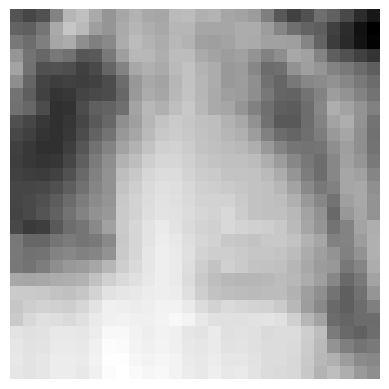

In [35]:
plt.imshow(images[0][0], cmap='gray')
plt.axis('off')

### **Task B-2:** Implement `unpatchify`

Next, you are asked to create the reverse function able to take in a batch of patches and return the corresponding batch of images.

In [36]:
def unpatchify(patches, patch_size, image_size, number_of_channels=1):
    ### TODO
    ### Write a function that takes a batch of patches (N, L, D) where D = patch_size**2*C
    ### and returns the batch of images (N, C, H, W)
    ### ADD YOUR CODE HERE
    
    N, L, _ = patches.shape
    patch_h, patch_w = patch_size
    img_h, img_w = image_size

    # Check if L matches the expected number of patches
    assert L == (img_h // patch_h) * (img_w // patch_w), "Number of patches does not match the image size"

    # Reshape patches to (N, H // patch_h, W // patch_w, patch_h, patch_w, C)
    patches = patches.view(N, img_h // patch_h, img_w // patch_w, patch_h, patch_w, number_of_channels)

    # Permute and reshape to get the final images (N, C, H, W)
    images = patches.permute(0, 5, 1, 3, 2, 4).contiguous().view(N, number_of_channels, img_h, img_w)
    return images

Check that after unpatchifying the patches obtained in the last cells, we get back to the original image batch.

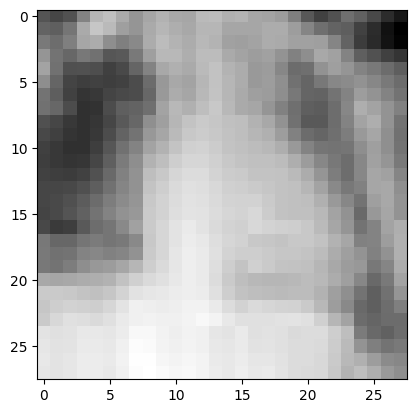

In [37]:
assert (unpatchify(patches, (4,4), (28,28)) == images).all()

### TODO plot the first image after applying patchify and unpatchify
### ADD YOUR CODE HERE

# Plot the original image
images = unpatchify(patches, (4, 4), (28, 28))
plt.imshow(images[0][0], cmap='gray')

### **Task B-3:** Implement `random_masking`

Next we need to write the function that will randomly mask out some of the patches for the encoder. We want to follow the approach described in the paper:

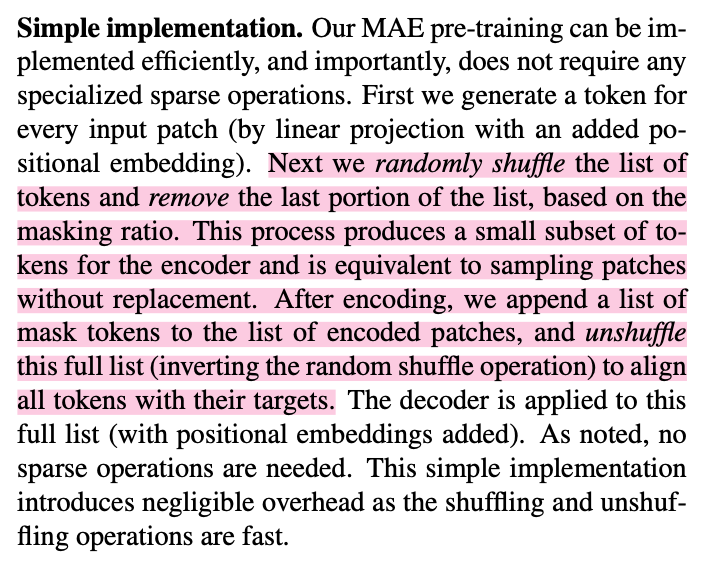

We implement the `random_masking` function.


This function takes the original patched batch of size (N, L, D) as input and returns:

* (a) `patches_kept`: the sequence of non-masked tokens
* (b) `mask`: a binary mask indicating which grid position are masked for every image in the batch
* (c) `ids_restore`: list of indices indicating how to revert the patch shuffling operation used to create the mask.

In [38]:
def random_masking(patches, mask_ratio):
        """
        Args:
            patches: original patched batch of size (N, L, D)
            mask_ratio: float between 0 and 1, the proportion of patches to mask in each image.

        Returns:
            patches_kept: tensor (N, L_kept, D) the sequence of non-masked patches (shuffled)
            mask: tensor (N, L) binary mask indicating which positions are masked (in the original patch grid)
            ids_restore: tensor (N, L) list of indices indicating how to un-shuffle the list of tokens.
        """

        N, L, D = patches.shape  # batch, length, dim

        # Step 1: create noise in [0, 1]
        ### ADD YOUR CODE HERE

        noise = torch.rand(N, L)

        # Step 2: sort noise for each sample
        ### ADD YOUR CODE HERE

        noise, indices = noise.sort(dim=1) 

        # Step 3: store list of indices to revert shuffling operation later
        ### ADD YOUR CODE HERE

        ids_restore = torch.argsort(indices, dim=1)

        # Step 4: used shuffled list to keep only a subset of patches
        ### ADD YOUR CODE HERE

        # Calculate the number of patches to keep
        L_kept = int(L * (1 - mask_ratio))      
        # Select the indices of the patches to keep (the first L_kept after sorting)
        indices_keep = indices[:, :L_kept]
    
        # Extract the patches to keep using gather
        patches_kept = torch.gather(patches, dim=1, index=indices_keep.unsqueeze(-1).expand(-1, -1, D))

        # Step 5 : generate the binary mask
        ### ADD YOUR CODE HERE
        
        # First, in the mixed order: the first L_kept are 0 (unmasked) and the rest 1 (masked)
        mask_shuffled = torch.ones(N, L, device=patches.device)
        mask_shuffled[:, :L_kept] = 0
        # Revert the permutation so that the mask corresponds to the original order of patches
        mask = torch.gather(mask_shuffled, dim=1, index=ids_restore)
        
        return patches_kept, mask, ids_restore

In [39]:
patches_kept, mask, ids_restore = random_masking(patches, 0.75)

Check the shapes of our outputs. Are there as expected?

In [40]:
patches_kept.shape, mask.shape, ids_restore.shape

(torch.Size([32, 12, 16]), torch.Size([32, 49]), torch.Size([32, 49]))

The original input is a batch of images represented as patches with a shape of (32, 49, 16), where 32 is the batch size, 49 represents the number of patches per image (which fits a 28×28 image when divided into a 7×7 grid), and 16 is patch_size**2*C. When applying a mask ratio of 0.75, only 25% of the patches are retained. Since 25% of 49 is approximately 12.25, the function truncates this value to 12 patches per image, resulting in a tensor for patches_kept with a shape of (32, 12, 16).

Additionally, the mask tensor is created to indicate which of the 49 patches in each image are masked (represented by 1s) or not (0s), and hence it retains the original patch count, yielding a shape of (32, 49). The ids_restore tensor, which is used to restore the original order of the patches, also has one entry per original patch, leading to the same shape of (32, 49).

Therefore, all the output shapes are as expected.

#### Visualisation of random masking
In this cell, we ask you to use the previously implemented functions `patchify`, `unpatchify` and `random_masking` to visualise the first three images in the validation batch at a masking ratio of 75% and 25%. Create a 2 x 3 subplots grids, the first row should be masked at 75%, the second one at 25%

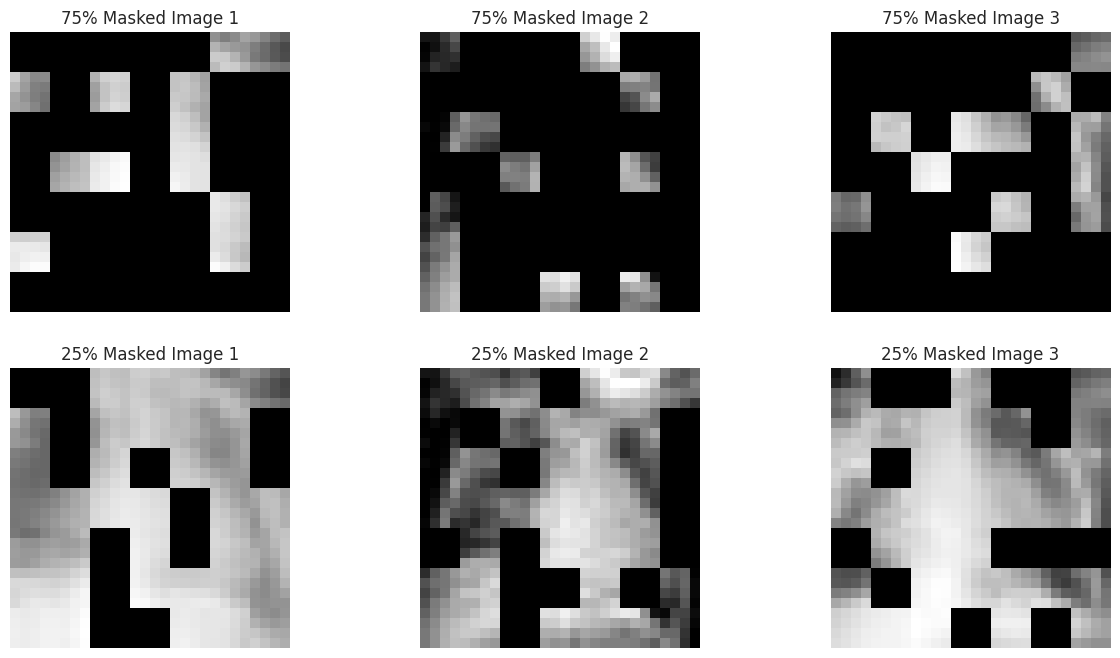

In [63]:
patch_size = (4,4)
images, _ = next(iter(datamodule.val_dataloader()))
batch_size = images.shape[0]

f, ax = plt.subplots(2, 3, figsize=(15, 8))


# Masking ratio 75%
for i in range(3):
    # Select the i-th image and add the batch dimension
    img = images[i].unsqueeze(0)  # Shape: (1, C, 28, 28)
    # Divide the image into patches
    patches = patchify(img, patch_size)  # (1, total_patches, D)
    # Apply random masking
    patches_kept, mask, ids_restore = random_masking(patches, 0.75)
    patches_restored = torch.zeros((1, patches.shape[1], patches.shape[2]), device=patches_kept.device)
    patches_restored[:, :patches_kept.shape[1], :] = patches_kept
    patches_restored = patches_restored[:, ids_restore[0]]
    # Reconstruct the image from the patches
    reconstructed = unpatchify(patches_restored, patch_size, (28,28))
    # For grayscale images, we extract the only channel (reconstructed[0][0] is of shape (28,28))
    ax[0, i].imshow(reconstructed[0][0].cpu().numpy(), cmap='gray')
    ax[0, i].set_title(f'75% Masked Image {i+1}')
    ax[0, i].axis('off')

# Masking ratio 25%
for i in range(3):
    img = images[i].unsqueeze(0)  # (1, C, 28, 28)
    patches = patchify(img, patch_size)
    patches_kept, mask, ids_restore = random_masking(patches, 0.25)
    patches_restored = torch.zeros((1, patches.shape[1], patches.shape[2]), device=patches_kept.device)
    patches_restored[:, :patches_kept.shape[1], :] = patches_kept
    patches_restored = patches_restored[:, ids_restore[0]]
    reconstructed = unpatchify(patches_restored, patch_size, (28,28))
    ax[1, i].imshow(reconstructed[0][0].cpu().numpy(), cmap='gray')
    ax[1, i].set_title(f'25% Masked Image {i+1}')
    ax[1, i].axis('off')

plt.show()

## **Part C**: Implement and train a full MAE model.

We will use the previously defined utility functions along with some helper code that we provide to implement the full training pipeline of Masked Auto-Encoder.

In the following, we provide code for creating the positional embeddings for the ViT. You do not need to implement anything here, just run this cell.

In [42]:
from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block

import numpy as np

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    if isinstance(grid_size, int):
        grid_size = (grid_size, grid_size)
    grid_h = np.arange(grid_size[0], dtype=np.float32)
    grid_w = np.arange(grid_size[1], dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size[0], grid_size[1]])

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    pos_embed = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)

    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.0
    omega = 1.0 / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum("m,d->md", pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

### **Task C-1:** MAE model implementation

In [43]:
class MaskedAutoencoderViT(LightningModule):

    def __init__(
        self,
        img_size=224,
        patch_size=16,
        in_chans=3,
        embed_dim=1024,
        depth=24,
        num_heads=16,
        decoder_embed_dim=512,
        decoder_depth=8,
        decoder_num_heads=16,
        mlp_ratio=4.0,
    ):
        super().__init__()

        # MAE encoder definition
        self.embed_dim = embed_dim
        self.in_chans = in_chans
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches
        print(self.patch_embed.grid_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False
        )

        self.blocks = nn.ModuleList(
            [
                Block(
                    embed_dim,
                    num_heads,
                    mlp_ratio,
                    qkv_bias=True,
                    norm_layer=nn.LayerNorm,
                )
                for i in range(depth)
            ]
        )
        self.norm = nn.LayerNorm(embed_dim)

        # MAE decoder definition
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
        self.decoder_pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False
        )

        self.decoder_blocks = nn.ModuleList(
            [
                Block(
                    decoder_embed_dim,
                    decoder_num_heads,
                    mlp_ratio,
                    qkv_bias=True,
                    norm_layer=nn.LayerNorm,
                )
                for i in range(decoder_depth)
            ]
        )

        self.decoder_norm = nn.LayerNorm(decoder_embed_dim)
        self.decoder_pred = nn.Linear(
            decoder_embed_dim, patch_size**2 * in_chans, bias=True
        )

        # Positional embeddings
        pos_embed = get_2d_sincos_pos_embed(
            embed_dim=self.pos_embed.shape[-1],
            grid_size=self.patch_embed.grid_size,
            cls_token=True,
        )
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(
            self.decoder_pos_embed.shape[-1],
            grid_size=self.patch_embed.grid_size,
            cls_token=True,
        )
        self.decoder_pos_embed.data.copy_(
            torch.from_numpy(decoder_pos_embed).float().unsqueeze(0)
        )


    def patchify(self, imgs):
        """
        imgs: (N, C, H, W)
        x: (N, L, D)
        """
        ### TODO: Use the previously defined function
        ### ADD YOUR CODE HERE
        N, C, H, W = imgs.shape
        patch_h, patch_w = patch_size

        # Check if H and W are divisible by patch size
        assert H % patch_h == 0, "H is not divisible by patch_h"
        assert W % patch_w == 0, "W is not divisible by patch_w"

        # Calculate number of patches
        L = (H // patch_h) * (W // patch_w)

        # Extract patches
        patches = imgs.unfold(2, patch_h, patch_h).unfold(3, patch_w, patch_w)

        # Calculate D
        D = patch_h * patch_w * C
        
        # Reshape patches to (N, L, D)
        patches = patches.reshape(N, L, D)

        return patches

    def configure_optimizers(self):
        ### TODO: configure the optimiser to be Adam with learning rate 1e-4
        ### ADD YOUR CODE HERE

        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def unpatchify(self, x):
        """
        x: (N, L, D)
        imgs: (N, C, H, W)
        """
        ### TODO: Use the previously defined function
        ### ADD YOUR CODE HERE

        N, L, _ = x.shape
        number_of_channels = self.in_chans
        patch_h, patch_w = self.patch_embed.patch_size
        img_h, img_w = self.patch_embed.img_size

        # Check if L matches the expected number of patches
        assert L == (img_h // patch_h) * (img_w // patch_w), "Number of patches does not match the image size"

        # Reshape patches to (N, H // patch_h, W // patch_w, patch_h, patch_w, C)
        patches = x.view(N, img_h // patch_h, img_w // patch_w, patch_h, patch_w, number_of_channels)

        # Permute and reshape to get the final images (N, C, H, W)
        imgs = patches.permute(0, 5, 1, 3, 2, 4).contiguous().view(N, number_of_channels, img_h, img_w)
        return imgs

    def random_masking(self, x, mask_ratio):
        #def random_masking(patches, mask_ratio):

        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        ### TODO: Use the previously defined function
        ### ADD YOUR CODE HERE
        
        x = x.to(self.pos_embed.device)
        N, L, D = x.shape  # batch, length, dim

        # Step 1: create noise in [0, 1]

        noise = torch.rand(N, L).to(x.device)

        # Step 2: sort noise for each sample

        noise, indices = noise.sort(dim=1) 

        # Step 3: store list of indices to revert shuffling operation later

        ids_restore = torch.argsort(indices, dim=1)

        # Step 4: used shuffled list to keep only a subset of patches

        # Calculate the number of patches to keep
        L_kept = int(L * (1 - mask_ratio))      
        # Select the indices of the patches to keep (the first L_kept after sorting)
        indices_keep = indices[:, :L_kept]
    
        # Extract the patches to keep using gather
        patches_kept = torch.gather(x, dim=1, index=indices_keep.unsqueeze(-1).expand(-1, -1, D))

        # Step 5 : generate the binary mask
        
        # First, in the mixed order: the first L_kept are 0 (unmasked) and the rest 1 (masked)
        mask_shuffled = torch.ones(N, L, device=x.device)
        mask_shuffled[:, :L_kept] = 0
        # Revert the permutation so that the mask corresponds to the original order of patches
        mask = torch.gather(mask_shuffled, dim=1, index=ids_restore)
        
        return patches_kept, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        """
        Forward function for the encoding part.
        """
        # embed patches (use self.patch_embed)
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        """
        Forward function for the decoding part.
        """
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(
            x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1
        )
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(
            x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2])
        )  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def compute_loss(self, target_patches, pred_patches, mask):
        """
        This function returns the MAE loss value for a given batch.
        Should be MSE loss over masked patches
        Args:
          target_patches: [N, L, D] ground truth patches
          pred_patches: [N, L, D] predicted patches
          mask: [N, L] binary mask indicating which patches are masked
        """
        ### TODO
        ### ADD YOUR CODE HERE

        mask = mask.unsqueeze(2)  # (N, L, 1) Add third dimension to mask
        masked_pred_patches = pred_patches * mask  # Masked predicted patches
        masked_target_patches = target_patches * mask  # Masked target patches
        loss = F.mse_loss(masked_pred_patches, masked_target_patches) # Loss
        return loss

    def forward(self, imgs, mask_ratio=0.75):
        """
        Forward function
        Args:
          imgs: batch of [N, C, H, W] images
          mask_ratio: masking ratio to use for the encoder

        Returns:
          predicted_patches [N, L, D], where D = patch_size[0]*patch_size[1]*C
          mask [N, L]
        """
        ### TODO
        ### ADD YOUR CODE HERE

        # Forward pass through the encoder
        x, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)

        # Forward pass through the decoder
        predicted_patches = self.forward_decoder(x, ids_restore)

        return predicted_patches, mask

    def training_step(self, batch, batch_idx):
        images = batch[0]
        predicted_patches, mask = self(images)
        target_patches = self.patchify(images)
        loss = self.compute_loss(target_patches, predicted_patches, mask)
        self.log('loss_train', loss, prog_bar=True)

        if batch_idx == 0:
            images_output = self.unpatchify(predicted_patches * mask.unsqueeze(2) + target_patches * (~mask.bool()).int().unsqueeze(2))
            grid = torchvision.utils.make_grid(images[0:4], nrow=4, normalize=True)
            self.logger.experiment.add_image('train_images_input', grid, self.global_step)
            grid = torchvision.utils.make_grid(images_output[0:4], nrow=4, normalize=True)
            self.logger.experiment.add_image('train_images_output', grid, self.global_step)
            grid = torchvision.utils.make_grid(self.unpatchify(target_patches * mask.unsqueeze(2))[0:4], nrow=4, normalize=True)
            self.logger.experiment.add_image('train_patches_target', grid, self.global_step)
            grid_predicted = torchvision.utils.make_grid(self.unpatchify(predicted_patches * mask.unsqueeze(2))[0:4], nrow=4, normalize=True)
            self.logger.experiment.add_image('train_patches_predicted', grid_predicted, self.global_step)
        return loss

    def validation_step(self, batch, batch_idx):
        images = batch[0]
        predicted_patches, mask = self(batch[0])
        target_patches = self.patchify(images)
        loss = self.compute_loss(target_patches, predicted_patches, mask)

        self.log('loss_val', loss, prog_bar=True)

    def get_class_embeddings(self, images):
        """
        Return the class embeddings extracted from the encoder
        for each image in the batch.
        This function is meant to be used at inference, we do not mask
        any patches.
        """
        embeddings, _, _ = self.forward_encoder(images, mask_ratio=0)
        return embeddings[:, 0, :]

    def predict_step(self, batch, batch_idx):
        images, labels = batch[0], batch[1]
        return {'embeddings': self.get_class_embeddings(images), 'labels': labels}

Next, we define a tiny toy VIT architecture for you to use in this coursework. This is much smaller than standard ViT architectures but will allow you to train your MAE rapidly on a single GPU. Note that we use again a patch size of 4 given the small resolution of the input images.

In [44]:
def mae_vit_toy_patch4_dec256d4b():
    """
    Creates a toy ViT with patch size 4.
    """
    model = MaskedAutoencoderViT(
        in_chans=1,
        img_size=28,
        patch_size=4,
        embed_dim=384,
        depth=6,
        num_heads=6,
        decoder_embed_dim=256,
        decoder_depth=4,
        decoder_num_heads=8,
        mlp_ratio=4,
    )
    return model

### **Task C-2:** MAE training

#### Tensorboard logging
Load tensorboard, we should be able to monitor training and validation loss as well as your reconstructed training images.

In [45]:
%reload_ext tensorboard
%tensorboard --logdir './lightning_logs/coursework/'

In [46]:
seed_everything(33, workers=True)

data = PneumoniaMNISTDataModule(batch_size=32)

device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = mae_vit_toy_patch4_dec256d4b()

trainer = Trainer(
    max_epochs=60, # Increased a bit because of the jump at the end in the loss
    accelerator='auto',
    devices=1,
    logger=TensorBoardLogger(save_dir='./lightning_logs/coursework/', name='mae_test'),
)
trainer.fit(model=model, datamodule=data)

Seed set to 33
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params | Mode 
------------------------------------------------------
0 | patch_embed    | PatchEmbed | 6.5 K  | train
1 | blocks         | ModuleList | 10.6 M | train
2 | norm           | LayerNorm  | 768    | train
3 | decoder_embed  | Linear     | 98.6 K | train
4 | decoder_blocks | ModuleList | 3.2 M  | train
5 | decoder_norm   | LayerNorm  | 512    | train
6 | decoder_pred   | Linear     | 4.1 K  | train
  | other params   | n/a        | 32.6 K | n/a  
------------------------------------------------------
13.9 M    Trainable params
32.0 K    Non-trainable params
13.9 M    Total params
55.796    Total estimated model params size (MB)
219       Modules in train mode
0         Modules in eval mode


Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
cuda
(7, 7)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eder/miniconda3/envs/mlimaging/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eder/miniconda3/envs/mlimaging/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.


## **Part D**: Inspect the trained model.

In this last part, we analyse the feature embeddings (or representations) obtained from your trained model with t-SNE. Let's see if our model learned anything useful!

### **Task D-1:** Inspect and compare the learned feature representations of your trained model.

We compare the feature embeddings of the trained model to embeddings obtained with a randomly initialised (untrained) model. We create some scatter plot visualisations and describe the findings with a few sentences.

In [47]:
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn import decomposition
import pandas as pd

Let's get the representations from our trained model:

In [48]:
class MaskedAutoencoderViTEmbeddings(MaskedAutoencoderViT):
    def __init__(
        self,
        img_size=224,
        patch_size=16,
        in_chans=3,
        embed_dim=1024,
        depth=24,
        num_heads=16,
        decoder_embed_dim=512,
        decoder_depth=8,
        decoder_num_heads=16,
        mlp_ratio=4.0,
    ):
        super().__init__(img_size, patch_size, in_chans, embed_dim, depth, num_heads, decoder_embed_dim, decoder_depth, decoder_num_heads, mlp_ratio)       
        self.embeddings = [] # list where we still store the embeddings

    def get_embedding(self, x, mask_ratio=0.75):
        x, _, _ = self.forward_encoder(x, mask_ratio)
        return x.view(x.size(0), -1)
    
    def on_test_start(self):
        self.embeddings = [] # clear the list of embeddings at the start of testing

    def test_step(self, batch, batch_idx):
        imgs, _ = batch
        emb = self.get_embedding(imgs)
        self.embeddings.append(emb)

In [50]:
model_dir = './lightning_logs/coursework/mae_test/version_0/checkpoints/epoch=31-step=4736.ckpt'

model_modified = MaskedAutoencoderViTEmbeddings.load_from_checkpoint(model_dir, in_chans=1, img_size=28, patch_size=4, embed_dim=384, depth=6, num_heads=6,
                                                                     decoder_embed_dim=256, decoder_depth=4, decoder_num_heads=8, mlp_ratio=4,)
trainer.test(model=model_modified, datamodule=data)
embeddings = torch.cat(model_modified.embeddings, dim=0).cpu().numpy()
print(embeddings.shape)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(7, 7)


/home/eder/miniconda3/envs/mlimaging/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

(624, 4992)


In [51]:
# Create a dataframe with the class labels
labels = np.array([data.test_set[i][1] for i in range(0,len(data.test_set))]).astype(np.uint8)
df = pd.DataFrame(labels, columns=['class_label'])

# Perform PCA on the embeddings
pca = decomposition.PCA(n_components=0.95, whiten=False)
embeddings_pca = pca.fit_transform(embeddings)

print("Embedding shape after PCA: ", embeddings_pca.shape)

# Add the PCA components to the dataframe
df['features - PCA 1'] = embeddings_pca[:,0]
df['features - PCA 2'] = embeddings_pca[:,1]
df['features - PCA 3'] = embeddings_pca[:,2]
df['features - PCA 4'] = embeddings_pca[:,3]

# Perform t-SNE on the embeddings
embeddings_tsne = TSNE(n_components=2, init='random', learning_rate='auto').fit_transform(embeddings_pca)

print("Embedding shape after PCA and TSNE: ", embeddings_tsne.shape)

# Add the t-SNE components to the dataframe
df['features - t-SNE 1'] = embeddings_tsne[:,0]
df['features - t-SNE 2'] = embeddings_tsne[:,1]

df.head() # showing the first five entries in the dataframe

Embedding shape after PCA:  (624, 201)
Embedding shape after PCA and TSNE:  (624, 2)


,class_label,features - PCA 1,features - PCA 2,features - PCA 3,features - PCA 4,features - t-SNE 1,features - t-SNE 2
0,1,3.908165,6.035489,4.070599,-1.341054,6.714702,4.483046
1,0,-13.897316,-11.915040,-12.110461,21.332968,-12.071618,-18.935572
2,1,7.879046,-15.328770,-3.921061,12.499488,-10.515244,5.817060
3,0,28.587406,-2.637968,1.720091,-4.516327,2.685032,24.806839
4,1,-16.083618,-1.692487,20.228897,4.549816,10.174796,-23.838036


In [52]:
# Convert the images into a numpy array and reshape them
images = np.array([data.test_set[i][0] for i in range(0,len(data.test_set))])
images = images.reshape(images.shape[0], -1) # linearize the 28x28 PneumoniaMNIST input images

print(images.shape)

# Perform PCA on the images
pca = decomposition.PCA(n_components=0.95, whiten=False)
images_pca = pca.fit_transform(images)

# Add the PCA components to the dataframe
df['images - PCA 1'] = images_pca[:,0]
df['images - PCA 2'] = images_pca[:,1]
df['images - PCA 3'] = images_pca[:,2]
df['images - PCA 4'] = images_pca[:,3]

print("Image shape after PCA: ", images_pca.shape)

# Perform t-SNE on the images
images_tsne = TSNE(n_components=2, init='random', learning_rate='auto').fit_transform(images_pca)

# Add the t-SNE components to the dataframe
df['images - t-SNE 1'] = images_tsne[:,0]
df['images - t-SNE 2'] = images_tsne[:,1]

print("Image shape after PCA and TSNE: ", images_tsne.shape)

df.head() # showing the first five entries in the dataframe

(624, 784)
Image shape after PCA:  (624, 64)
Image shape after PCA and TSNE:  (624, 2)


,class_label,features - PCA 1,features - PCA 2,features - PCA 3,features - PCA 4,features - t-SNE 1,features - t-SNE 2,images - PCA 1,images - PCA 2,images - PCA 3,images - PCA 4,images - t-SNE 1,images - t-SNE 2
0,1,3.908165,6.035489,4.070599,-1.341054,6.714702,4.483046,1.151141,1.155634,0.514709,0.568803,-8.065016,7.650887
1,0,-13.897316,-11.915040,-12.110461,21.332968,-12.071618,-18.935572,-1.344363,0.921526,-0.912863,0.235994,-4.263399,-12.429540
2,1,7.879046,-15.328770,-3.921061,12.499488,-10.515244,5.817060,-1.260537,-1.253868,-1.409327,-0.374693,11.294152,-8.491688
3,0,28.587406,-2.637968,1.720091,-4.516327,2.685032,24.806839,0.816416,-2.380242,1.256400,-0.100683,15.995051,11.126574
4,1,-16.083618,-1.692487,20.228897,4.549816,10.174796,-23.838036,-0.618357,1.431751,1.224740,0.185187,-12.931520,1.693749


In [53]:
# Define the plotting parameters
alpha = 0.8
style = 'o'
markersize = 40
color_palette = 'tab10'
kind = 'scatter'

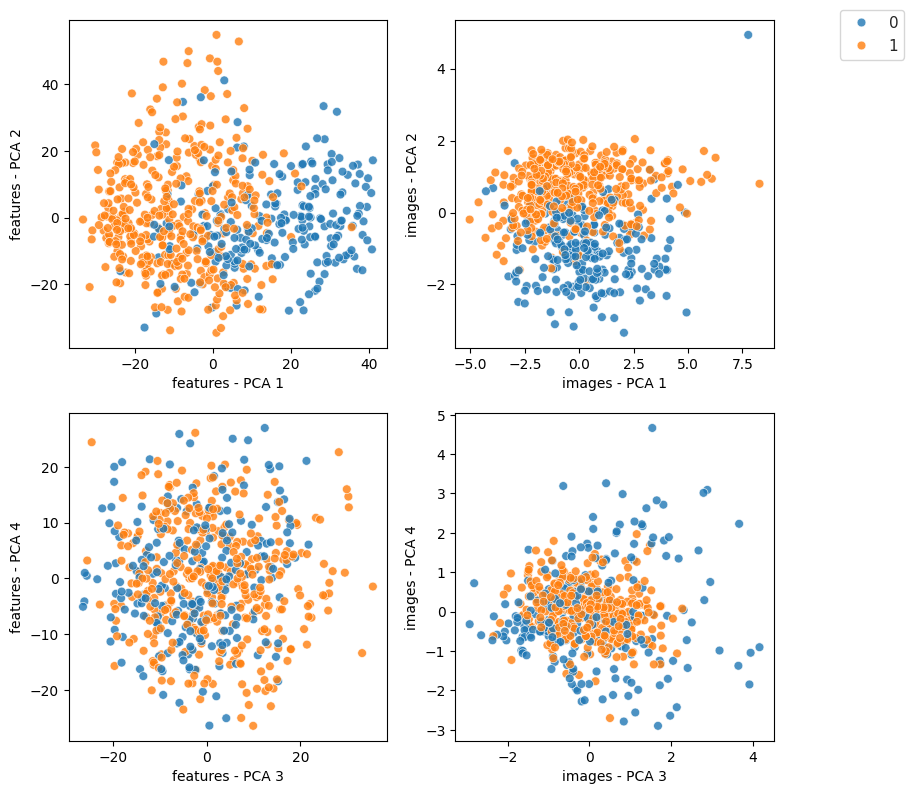

In [54]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
sns.set_theme(style="white")

# First plot: we leave the legend active to extract it later
ax0 = axs[0, 0]
sns.scatterplot(ax=axs[0, 0], data=df, x='features - PCA 1', y='features - PCA 2', 
                hue='class_label', alpha=alpha, marker=style, s=markersize, 
                palette=color_palette)
# Extract the handles and labels
handles, labels = ax0.get_legend_handles_labels()
# Remove the legend from the first subplot
if ax0.get_legend() is not None:
    ax0.get_legend().remove()

# Second plot
sns.scatterplot(ax=axs[0, 1], data=df, x='images - PCA 1', y='images - PCA 2', 
                hue='class_label', alpha=alpha, marker=style, s=markersize, 
                palette=color_palette, legend=False)

# Third plot
sns.scatterplot(ax=axs[1, 0], data=df, x='features - PCA 3', y='features - PCA 4', 
                hue='class_label', alpha=alpha, marker=style, s=markersize, 
                palette=color_palette, legend=False)

# Fourth plot
sns.scatterplot(ax=axs[1, 1], data=df, x='images - PCA 3', y='images - PCA 4', 
                hue='class_label', alpha=alpha, marker=style, s=markersize, 
                palette=color_palette, legend=False)

# Create the global legend
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

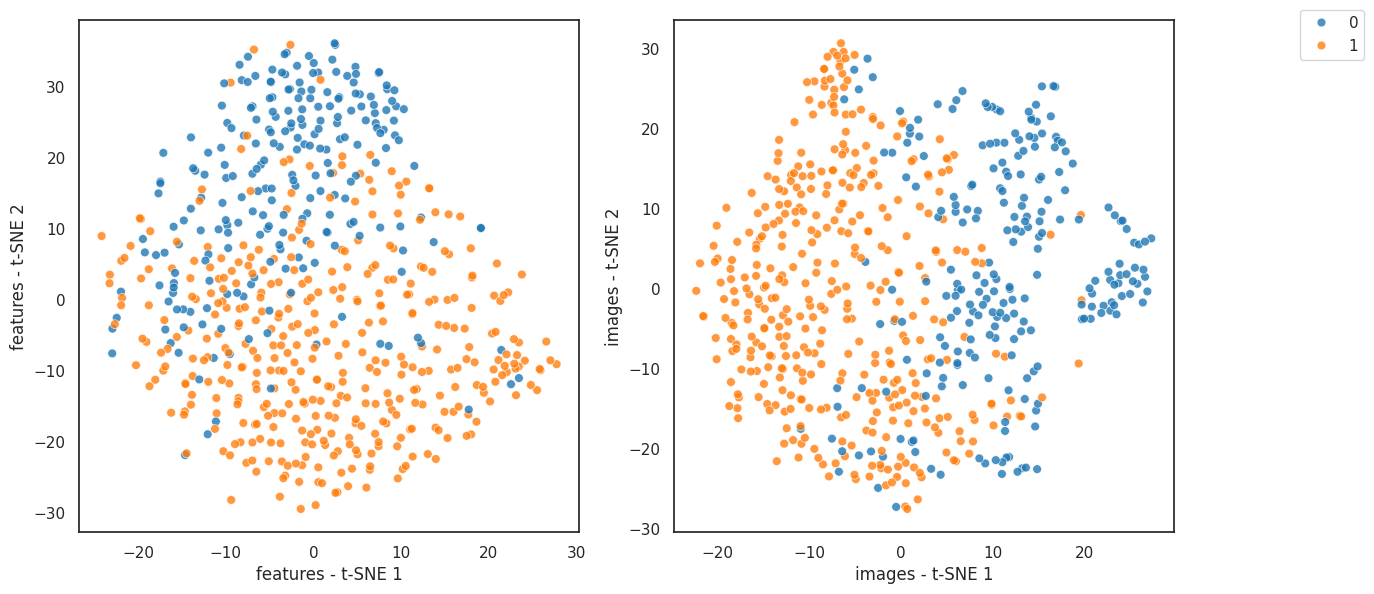

In [55]:
# Know we plot the results for the t-SNE embeddings
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.set_theme(style="white")

ax0 = axs[0]
sns.scatterplot(ax=ax0, data=df, x='features - t-SNE 1', y='features - t-SNE 2', 
                hue='class_label', alpha=alpha, marker=style, s=markersize, 
                palette=color_palette)
handles, labels = ax0.get_legend_handles_labels()
if ax0.get_legend() is not None:
    ax0.get_legend().remove()

sns.scatterplot(ax=axs[1], data=df, x='images - t-SNE 1', y='images - t-SNE 2', 
                hue='class_label', alpha=alpha, marker=style, s=markersize, 
                palette=color_palette, legend=False)

# Create the global legend
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

In [56]:
import matplotlib as mpl
import plotly.graph_objs as go
import plotly.express as px
from matplotlib import cm
from ipywidgets import Output, HBox

In [57]:
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(rgb[0], rgb[1], rgb[2])

color = cm.tab10(np.linspace(0, 1, 10))
colorlist = [(np.array(mpl.colors.to_rgb(c))*255).astype(int).tolist() for c in color]*10

colors = [rgb_to_hex(colorlist[label]) for label in df.class_label.values]

In [58]:
x = 'features - t-SNE 1'
y = 'features - t-SNE 2'

out = Output()
@out.capture(clear_output=True)
def handle_click(trace, points, state):
    idx = df.index.values[points.point_inds[0]]
    img = images[idx, :]
    
    s = [8] * len(df)
    for i in points.point_inds:
        s[i] = 16
    with fig.batch_update():
        scatter.marker.size = s

    f, ax = plt.subplots(1,1, figsize=(4,4))
    ax.imshow(img.reshape((28,28)), cmap='gray')
    ax.axis('off')
    plt.show(f)
    
fig = go.FigureWidget(px.scatter(df, x=x, y=y, template='plotly_white', hover_data={'class_label': True, x:False, y:False}))
fig.update_layout(width=600, height=600)
scatter = fig.data[0]
scatter.on_click(handle_click)
scatter.marker.size = [8] * len(df)
scatter.marker.color = colors

HBox([fig, out])

    'data': [{'customdata': array([[1],
                                   [0],
…

Let's compare with the representation of an untrained model

In [59]:
# Create the untrained model
untrained_model = MaskedAutoencoderViTEmbeddings(in_chans=1, img_size=28, patch_size=4, embed_dim=384, depth=6, num_heads=6,
                                                                     decoder_embed_dim=256, decoder_depth=4, decoder_num_heads=8, mlp_ratio=4,)
trainer.test(model=untrained_model, datamodule=data)
embeddings = torch.cat(untrained_model.embeddings, dim=0).cpu().numpy()
print(embeddings.shape)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(7, 7)


/home/eder/miniconda3/envs/mlimaging/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning:

The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Testing: |          | 0/? [00:00<?, ?it/s]

(624, 4992)


In [60]:
# Create a dataframe with the class labels for the untrained model
labels = np.array([data.test_set[i][1] for i in range(0,len(data.test_set))]).astype(np.uint8)
df = pd.DataFrame(labels, columns=['class_label'])

# Perform PCA on the embeddings
pca = decomposition.PCA(n_components=0.95, whiten=False)
embeddings_pca = pca.fit_transform(embeddings)

print(embeddings_pca.shape)

# Add the PCA components to the dataframe
df['features - PCA 1'] = embeddings_pca[:,0]
df['features - PCA 2'] = embeddings_pca[:,1]
df['features - PCA 3'] = embeddings_pca[:,2]
df['features - PCA 4'] = embeddings_pca[:,3]

# Perform t-SNE on the embeddings
embeddings_tsne = TSNE(n_components=2, init='random', learning_rate='auto').fit_transform(embeddings_pca)

print(embeddings_tsne.shape)

# Add the t-SNE components to the dataframe
df['features - t-SNE 1'] = embeddings_tsne[:,0]
df['features - t-SNE 2'] = embeddings_tsne[:,1]

df.head() # showing the first five entries in the dataframe

(624, 62)
(624, 2)


,class_label,features - PCA 1,features - PCA 2,features - PCA 3,features - PCA 4,features - t-SNE 1,features - t-SNE 2
0,1,0.085608,-2.314194,3.707670,-2.359124,1.803094,-1.547044
1,0,0.716355,5.428017,3.517769,4.926601,-5.493159,13.958353
2,1,-1.473587,4.459114,3.500272,-0.861529,-18.851530,4.424058
3,0,0.858930,-8.287944,-3.508290,4.701985,10.046527,-13.687622
4,1,-1.767120,-5.695096,-8.738058,3.342774,6.433622,-9.634429


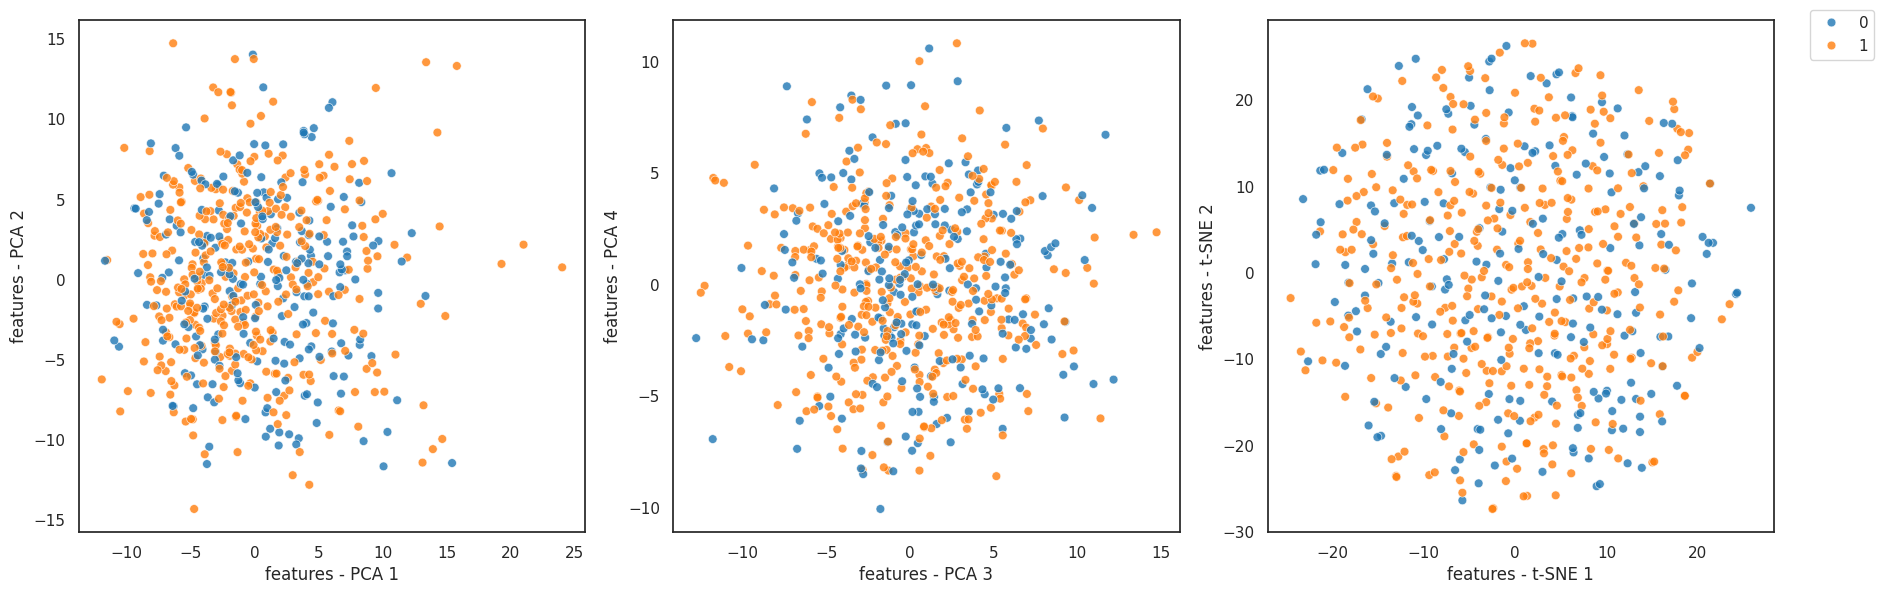

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
sns.set_theme(style="white")

# Firts plot
ax0 = axs[0]
sns.scatterplot(ax=ax0, data=df, x='features - PCA 1', y='features - PCA 2', 
                hue='class_label', alpha=alpha, marker=style, s=markersize, 
                palette=color_palette)
handles, labels = ax0.get_legend_handles_labels()
# Remove the legend from the first subplot
if ax0.get_legend() is not None:
    ax0.get_legend().remove()

# Sedond plot
sns.scatterplot(ax=axs[1], data=df, x='features - PCA 3', y='features - PCA 4', 
                hue='class_label', alpha=alpha, marker=style, s=markersize, 
                palette=color_palette, legend=False)

# Third plot
sns.scatterplot(ax=axs[2], data=df, x='features - t-SNE 1', y='features - t-SNE 2', 
                hue='class_label', alpha=alpha, marker=style, s=markersize, 
                palette=color_palette, legend=False)

# General legend
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


### Analysis

The scatter plots of the first two PCA components reveal a significantly better separation of class labels compared to the third and fourth components. A similar trend appears when PCA is applied directly to the raw images—the first two dimensions yield much clearer class separation, suggesting that these dimensions are the most informative.

Furthermore, when t-SNE is applied to the PCA outputs, the visual discrimination of the labels is further enhanced. In the case of the embeddings, t-SNE produces a more distinct separation between the two groups, although some misclassified instances still persist. A comparable improvement is evident when t-SNE is applied to the PCA-reduced images, with the classes becoming more distinguishable even though a few samples remain ambiguous. This outcome is intuitive since PCA alone may discard certain dimensions that contain relevant information, whereas t-SNE, by capturing the nonlinear structure in the data, offers a more holistic visualization.

In stark contrast, the visualizations derived from the embeddings of an untrained model—both via PCA and t-SNE—show the classes to be completely intermixed. This stark difference underscores the critical role of training in enabling the model to learn discriminative features.

The interactive visualizations also reveal that while some misclassifications are understandable due to the inherent ambiguity of certain samples, others are less intuitive. Although the trained model exhibits a marked improvement over its untrained counterpart, the presence of misclassified instances in the t-SNE plots indicates that there is still room for refinement.

Rather than simply increasing the number of epochs—which would probably further reduce the training loss as we see in the validation plot—a better improvement could involve incorporating a contrastive learning objective into the training process. By integrating a contrastive loss (or even a triplet loss), the model would be encouraged to pull together similar samples while pushing apart dissimilar ones in the latent space, potentially resulting in a more robust and discriminative feature representation. This approach could lead to a more finely tuned model that better separates the classes in its embeddings.